In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import h5py

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from kerastuner.tuners import RandomSearch
import keras_tuner as kt
from glob import glob
import kerastuner as kt
from kerastuner import HyperParameters

print("Importações e dependencias adicionadas com sucesso.")

Importações e dependencias adicionadas com sucesso.


### DataPath

Contagem do número de ficheiros e quantidade de imagens em cada classe de doença de pele (**Urticaria**, **Psoriasis**, **Lupus**, **Dermatite**, **Melanoma**).

| Classe de Doença de Pele                                     | Conjunto de Treino | Conjunto de Teste |
|---------------------------------------------------------------|--------------------|-------------------|
| URTICARIA HIVES                                              | 416                | 53                |
| PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES        | 483                | 350               |
| LUPUS AND OTHER CONNECTIVE TISSUE DISEASES                   | 416                | 105               |
| ATOPIC DERMATITIS PHOTOS                                     | 483                | 123               |
| MELANOMA SKIN CANCER NEVI AND MOLES                          | 453                | 115               |

Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 483
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 416
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 453
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 483
Total number of images in [URTICARIA HIVES] in train set: 416
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 115
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 350
Total number of images in [URTICARIA HIVES] in test set: 53
Labels:  ['Atopic Dermatitis Photos', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis pictures Lichen Planus and related diseases', 'Urticaria Hives']

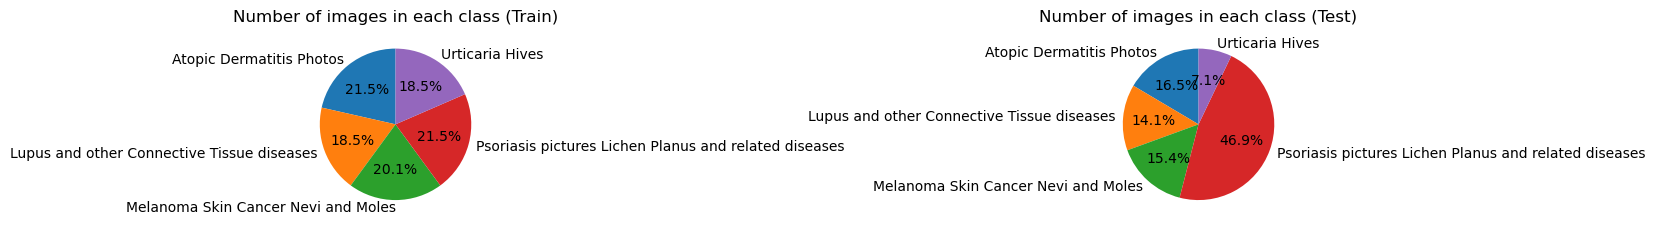

In [2]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
#train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
#test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

train_folder= 'C:/Dev/DataProcessed/train'
test_folder = 'C:/Dev/DataProcessed/test'


# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

y=list(train_diseases.keys())
print("Labels: ",y)

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

## Defnição de funções 

### Obtenção dos Dados de Treino, Validação e Teste

Definição de uma função para obter os dados de treino, validação e teste.

#### Funcionalidades Principais:

- **Função `get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32)`:** Retorna geradores de dados para treino, validação e teste.
- **Pré-processamento dos Dados de Treino:** Utiliza `ImageDataGenerator` para aplicar transformações nos dados de treino, como redimensionamento, normalização e aumento de dados.
- **Divisão em Conjuntos de Treino e Validação:** Divide os dados de treino em conjuntos de treino e validação.
- **Pré-processamento dos Dados de Teste:** Aplica redimensionamento e normalização nos dados de teste.
- **Geradores de Dados:** Cria geradores de dados para treino, validação e teste, utilizando as configurações definidas.


In [3]:
def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # Fixando a divisão em 80% treino e 20% validação
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    # Carregar dados de treinamento e validação
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Define o subset como treinamento
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Define o subset como validação
        seed=10
    )

    # Obtendo o mapeamento de classes para índices
    class_indices = train_generator.class_indices

    # Invertendo o mapeamento para obter índices para classes
    indices_class = {v: k for k, v in class_indices.items()}

    # Inicializando um contador para cada classe
    class_counts_train = {class_name: 0 for class_name in indices_class.values()}

    # Iterando sobre o diretório de treinamento e contando o número de imagens em cada classe
    for class_name in class_counts_train.keys():
        class_folder = os.path.join(train_folder, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts_train[class_name] = num_images

    # Data augmentation para o conjunto de teste
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de teste
    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtendo o número de imagens por classe no conjunto de teste
    class_counts_test = {class_name: len(os.listdir(os.path.join(test_folder, class_name))) for class_name in class_counts_train.keys()}

    # Obtendo o número de imagens por classe no conjunto de validação
    class_counts_validation = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_counts_train.keys()}

    # Imprimindo o número de imagens para cada classe no conjunto de validação
    print("\nNúmero de imagens por classe no conjunto de validação:")
    for class_name, count in class_counts_validation.items():
        print(f"Classe: {class_name}, Número de Imagens: {count}")
    
    return train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation

train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation = get_data(train_folder, test_folder)

# Imprimindo o número de imagens para cada classe no conjunto de treinamento
print("Número de imagens por classe no conjunto de treinamento:")
for class_name, count in class_counts_train.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de validação
print("\nNúmero de imagens por classe no conjunto de validação:")
for class_name, count in class_counts_validation.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de teste
print("\nNúmero de imagens por classe no conjunto de teste:")
for class_name, count in class_counts_test.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")


Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Número de imagens por classe no conjunto de treinamento:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Númer

In [12]:
train_img,train_lables = train_generator.next()
test_img,test_lables = test_generator.next()

print(train_img.shape)
print(test_img.shape)

(32, 250, 250, 3)
(32, 250, 250, 3)


### Treino dos Modelos

Definição de uma função para treinar os modelos de classificação.

#### Funcionalidades Principais:

- **Função `train_model(model, train_generator, validation_generator, epochs)`:** Compila e treina o modelo de classificação.
- **Compilação do Modelo:** Utiliza o otimizador 'adam' e a função de perda 'categorical_crossentropy' para compilar o modelo. Além disso, utiliza a métrica de accuracy e precisão durante o treino.
- **Treino do Modelo:** Treina o modelo utilizando os geradores de dados de treino e validação, durante o número especificado de épocas.
- **Retorno do Modelo e Histórico:** Retorna o modelo treinado e o histórico de treino.


In [4]:
# Função para treinar os modelos
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

### Avaliação dos Modelos

Definição de uma função para avaliar o desempenho dos modelos.

#### Funcionalidades Principais:

- **Função `evaluate_model(model, history, test_generator, test_folder)`:** Avalia o modelo de classificação.
- **Previsões:** Utiliza o modelo para fazer previsões sobre os dados de teste.
- **Conversão das Previsões para Rótulos:** Converte as previsões em rótulos para comparação com os rótulos verdadeiros.
- **Cálculo da Precisão, Recall e AUC:** Calcula a precisão, recall e AUC do modelo utilizando as previsões e os rótulos verdadeiros.
- **Visualização dos Resultados:** Plot da precisão, recall, AUC, bem como a precisão e perda de treino e validação em cada época.

In [5]:
# Função para avaliar os modelos
def evaluate_model(model, history, test_generator, test_folder): 
    # Prever
    y_pred = model.predict(test_generator)

    # Converter as previsões em rótulos
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calcular precisão, recall e exatidão
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # O cálculo da AUC não é possível sem y_score (probabilidades de classe)
    # auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted', multi_class='ovr')

    # Gráfico da precisão e perda de treino e validação em cada época
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    # Gráfico da precisão de treino e validação do modelo
    plt.plot(history.history['accuracy'], label='Precisão de Treino')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico da perda de treino e validação em cada época
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    # print("AUC:", auc)

    plt.show()

### Guardar os Modelos

Definição de uma função para salvar os modelos treinados, juntamente com sua avaliação e histórico de treino.

#### Funcionalidades Principais:

- **Função `save_model(model, model_name, history, train_folder)`:** Salva o modelo treinado, sua avaliação e histórico de treinamento.
- **Criação de Pastas:** Cria pastas para salvar o modelo, a avaliação e o histórico, se não existirem.
- **Salvamento do Modelo:** Salva o modelo treinado em formato h5.
- **Avaliação do Modelo:** Avalia o modelo e salva a avaliação em uma figura.
- **Salvamento da Arquitetura do Modelo:** Plota e salva a arquitetura do modelo em uma imagem.
- **Salvamento do Histórico de Treinamento:** Salva o histórico de treinamento em um arquivo CSV.


In [6]:
# Função para guardar os modelos
def save_model(model, model_name, history, train_folder, test_folder, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

### Matrix de Confussão

Definição de uma função para mostrar a matriz de confussão associada a um dado modelo

#### Funcionalidades Principais:

- **Função `confussion_matrix(y_true_labels, y_pred_labels, test_generator)`:** Calcula a matriz de confusão, exibindo-a em um gráfico de calor. Além disso, mostra o relatório de classificação e os valores de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN).
  - **Cálculo da Matriz de Confusão:** Utiliza a função `confusion_matrix` para calcular a matriz de confusão com as etiquetas verdadeiras e preditas.
  - **Exibição da Matriz de Confusão:** Plota a matriz de confusão em um gráfico de calor, utilizando a biblioteca seaborn para uma melhor visualização.
  - **Relatório de Classificação:** Mostra um resumo do desempenho do modelo, incluindo métricas como precisão, recall e F1-score para cada classe.
  - **Cálculo dos Valores de TP, TN, FP, FN:** Calcula e exibe os valores de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

In [7]:
def confussion_matrix(y_true_labels,y_pred_labels,test_generator):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN),
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

## Modelos


### Tuning

Possui 3 metodos diferentes para arranjar os melhores hiperparametros:
    - **1.1** Metodo Random Search
    - **1.2** Metodo Hyperband 
    - **1.3** Metodo Grid Search
    

In [ ]:
#WORK---- METODO RANDOM SEARCH

def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv1_units', min_value=32, max_value=256, step=32), kernel_size=(3, 3), activation='relu', input_shape=(250, 250, 3), padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=hp.Int('conv2_units', min_value=32, max_value=256, step=32), kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=hp.Int('conv3_units', min_value=32, max_value=256, step=32), kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        GlobalAveragePooling2D(),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'),
        Dense(units=5, activation='softmax')
    ])
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])
    opt=Adam(learning_rate=hp_learning_rate)#,momentum=0.9
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("A iniciar o RandomSearch")
# Criando o tuner de busca aleatória
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # Change this to higher value for more trials
    executions_per_trial=1,
    directory='test_tuner')

# Realizando a procura de hiperparâmetros
tuner.search(train_img, train_lables,
             epochs=10,  # Increase this as needed
             validation_data=(test_img, test_lables),
             batch_size=32)

# Obtendo o melhor modelo
#É UMA DAS LINHAS DE BAIXO
best_model = tuner.get_best_models(num_models=1)[0]
#best_model = tuner.get_best_models(num_models=1)
print("MODEL",best_model)

print("sUMMARY TUNNER",tuner.results_summary())
    
# Avaliação do modelo
history = best_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
evaluate_model(best_model, history, test_generator, test_folder)
    
# Previsão usando o conjunto de teste
y_pred = best_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_generator.classes
    
# Matriz de confusão
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_matrix)

# Salvando o modelo
# save_model(best_model, 'CNN_model', history, train_folder, test_folder, test_generator)


In [24]:
#WORK---- METODO HYPERBAND()

# Define a more complex model architecture
def build_model(hp):  
    model = Sequential()
    model.add(Conv2D(hp.Int("conv1", min_value=32, max_value=96, step=32), (3, 3), padding="same", input_shape=input_shape))
    # Adicione mais camadas conforme necessário
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))  

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define hyperparameters and other configurations
input_shape = (250, 250, 3)
num_classes = 5  
EPOCHS = 2
EARLY_STOPPING_PATIENCE = 3

# Initialize Hyperband tuner
tuner = kt.Hyperband(build_model, objective="val_accuracy", max_epochs=EPOCHS, factor=3, seed=42, directory='./', project_name='my_hyperband_tuner')

# Define additional callbacks
earlyStopper = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs')

# Perform hyperparameter search
tuner.search(train_generator, validation_data=test_generator, batch_size=32, callbacks=[earlyStopper, tensorboard_callback], epochs=EPOCHS)

Trial 26 Complete [00h 08m 46s]
val_accuracy: 0.4128686189651489

Best val_accuracy So Far: 0.4209115207195282
Total elapsed time: 01h 52m 57s


In [ ]:
#WORKS- GRIDSEARCH

# Definição da arquitetura da CNN
def CNN_model(filters, kernel_size, input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=filters//2, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=filters//4, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

    return model


def grid_search(train_folder, test_folder, param_grid, epochs=2):
    best_accuracy = 0
    best_params = None
    
    for filters in param_grid['filters']:
        for kernel_size in param_grid['kernel_size']:
            print(f"Training model with filters={filters}, kernel_size={kernel_size}")
            model = CNN_model(filters=filters, kernel_size=kernel_size)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
            accuracy = history.history['val_accuracy'][-1]  # Use validation accuracy as the metric
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'filters': filters, 'kernel_size': kernel_size}
                
    print("Best parameters:", best_params)
    print("Best validation accuracy:", best_accuracy)
    
    # Now you can train the final model with the best parameters
    final_model = CNN_model(filters=best_params['filters'], kernel_size=best_params['kernel_size'])
    final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    final_history = final_model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Evaluate the final model
    evaluate_model(final_model, final_history, test_generator, test_folder)
    save_model(final_model, 'CNN_model', final_history, train_folder, test_folder, test_generator)


param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [(3, 3), (5, 5)]
}

train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)

grid_search(train_folder, test_folder, param_grid)

### CNN 2D

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Epoch 1/50
57/57 [==============================] - 234s 4s/step - loss: 1.6076 - accuracy: 0.2069 - val_loss: 1.6047 - val_accuracy: 0.2522
Epoch 2/50
57/57 [==============================] - 228s 4s/step - loss: 1.5881 - accuracy: 0.2540 - val_loss: 1.5714 - val_accuracy: 0.3013
Epoch 3/50
57/57 [==============================] - 227s 4s/step - loss: 1.5382 - accuracy: 0.3106 - val_loss: 1.5888 - val_accuracy: 0.2991
Epoch 4/50
57/57 [==============================] - 228s 4s/ste

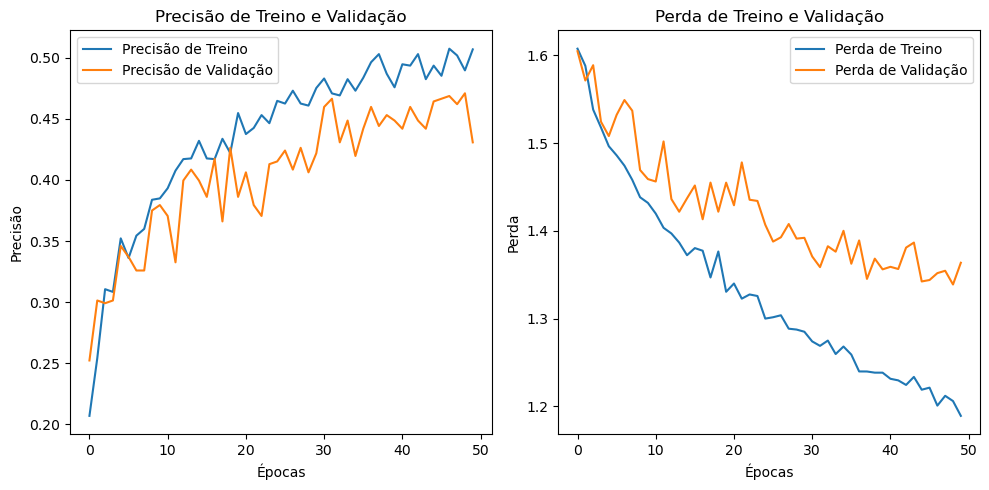

24/24 [==============================] - 13s 519ms/step


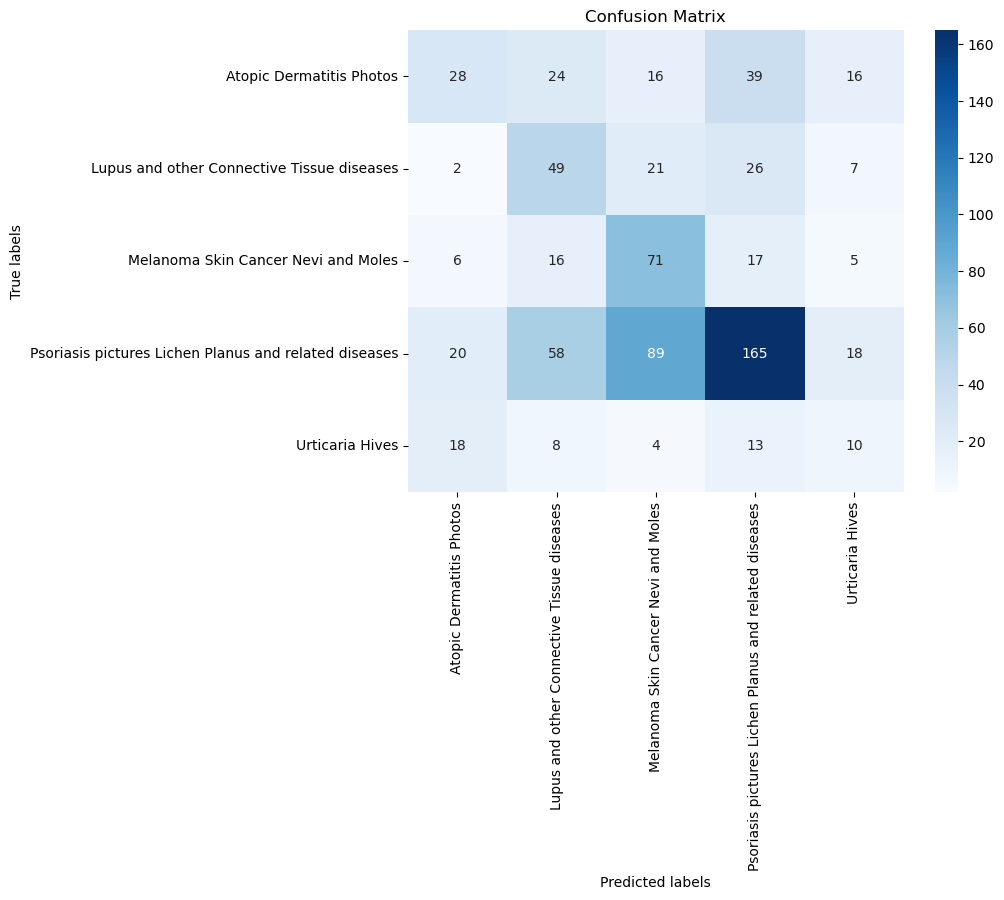


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.38      0.23      0.28       123
           Lupus and other Connective Tissue diseases       0.32      0.47      0.38       105
                  Melanoma Skin Cancer Nevi and Moles       0.35      0.62      0.45       115
Psoriasis pictures Lichen Planus and related diseases       0.63      0.47      0.54       350
                                      Urticaria Hives       0.18      0.19      0.18        53

                                             accuracy                           0.43       746
                                            macro avg       0.37      0.39      0.37       746
                                         weighted avg       0.47      0.43      0.44       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 49
Verdadeiros Negativos: 28
Falsos Positivos: 24
Falsos Negat

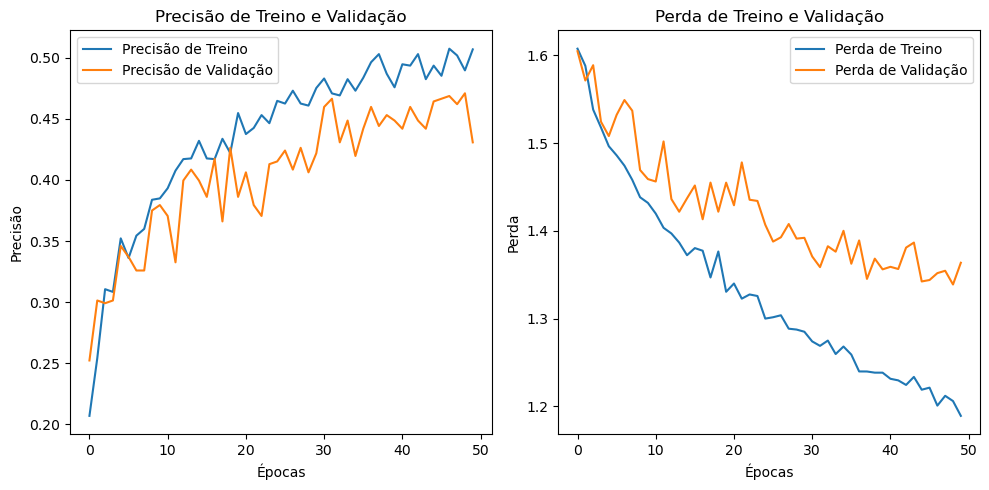

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<Figure size 640x480 with 0 Axes>

In [7]:
# Definição da arquitetura da CNN
def CNN_model(input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

    return model

# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=50):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo CNN
    model = CNN_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)

    #Verificcar se o y_pred e o y_pred_labels estao direitos
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)

    # Guardar o modelo
    save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

# Execução do modelo CNN
run_cnn_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = CNN_model()

# Sumário do modelo
model.summary()

### ResNet50

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Epoch 1/50
57/57 [==============================] - 342s 6s/step - loss: 2.0152 - accuracy: 0.2995 - val_loss: 1.6252 - val_accuracy: 0.1853
Epoch 2/50
57/57 [==============================] - 328s 6s/step - loss: 1.4943 - accuracy: 0.3444 - val_loss: 1.6223 - val_accuracy: 0.1853
Epoch 3/50
57/57 [==============================] - 329s 6s/step - loss: 1.4584 - accuracy: 0.3461 - val_loss: 2.1733 - val_accuracy: 0.1853
Epoch 4/50
57/57 [==============================] - 328s 6s/ste

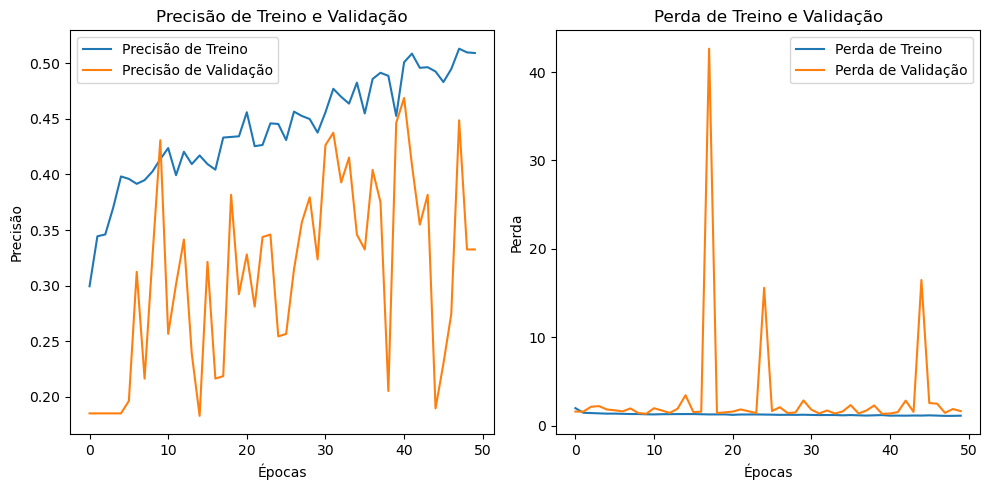

24/24 [==============================] - 41s 2s/step


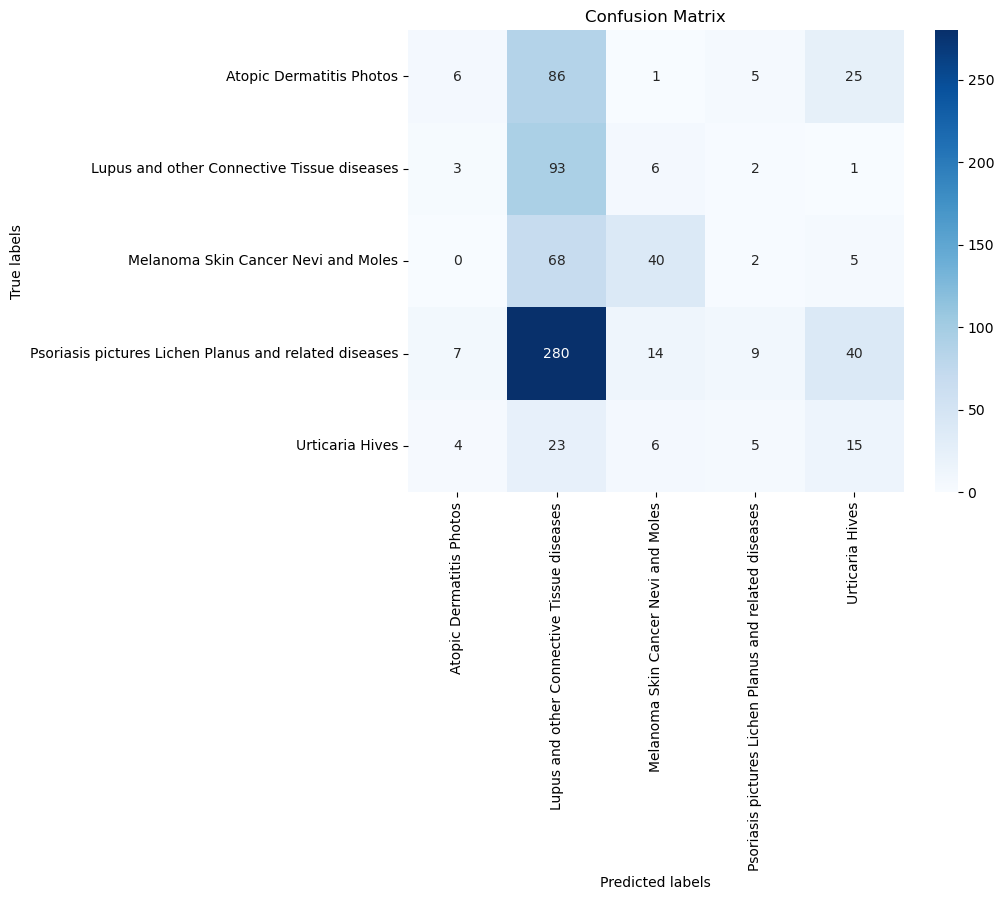


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.30      0.05      0.08       123
           Lupus and other Connective Tissue diseases       0.17      0.89      0.28       105
                  Melanoma Skin Cancer Nevi and Moles       0.60      0.35      0.44       115
Psoriasis pictures Lichen Planus and related diseases       0.39      0.03      0.05       350
                                      Urticaria Hives       0.17      0.28      0.22        53

                                             accuracy                           0.22       746
                                            macro avg       0.33      0.32      0.21       746
                                         weighted avg       0.36      0.22      0.16       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 93
Verdadeiros Negativos: 6
Falsos Positivos: 86
Falsos Negati

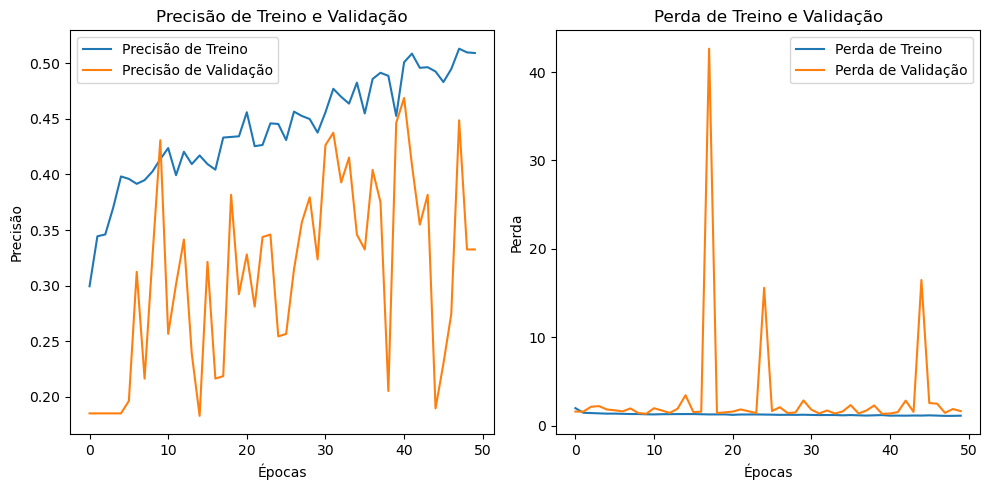

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<Figure size 640x480 with 0 Axes>

In [10]:
# Definição da arquitetura da ResNet
def ResNet_model(input_shape=(250, 250, 3)):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=50):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo ResNet
    model = ResNet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    
    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo ResNet
run_resnet_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

### VGG16

In [ ]:
# Função para definir a arquitetura do modelo VGG16
def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Redimensionar as imagens de entrada para 224x224 para corresponder à forma de entrada do VGG16
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importar o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Remover a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Camada de saída
    x = Flatten()(vgg16_layer)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

from sklearn.metrics import confusion_matrix, classification_report

# Execução do modelo VGG16
def run_vgg16_model(train_folder, test_folder, epochs=50):
    # Obtenção de dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo VGG16
    model = VGG16_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
     confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    # Guardar o modelo
    save_model(model, 'VGG16_model', history, train_folder, test_folder, test_generator)

# Execução do modelo VGG16
run_vgg16_model(train_folder, test_folder)


In [ ]:
# Obter o modelo
model = VGG16_model()

# Sumário do modelo 
model.summary()